In [227]:
! pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1
! pip install graphviz fastai pandas scikit-learn dtreeviz IPython opendatasets numpy matplotlib seaborn xgboost lightgbm --upgrade --quiet


In [228]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from fastai.imports import *
import pandas as pd
import numpy as np
import opendatasets as od
import os
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [229]:
creds = '{"username":"alishaikhhusain","key":"8e997994b86665a851cae21c41599ee8"}'

In [230]:
# downloading the dataset using the opendatasets library to download the dataset directly from kaggle & to use 
# it inside the jupyter notebook
od.download('https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data')

Skipping, found downloaded files in "./flight-price-prediction" (use force=True to force download)


In [231]:
os.listdir('flight-price-prediction')

['economy.csv', 'Clean_Dataset.csv', 'business.csv']

In [232]:
df = pd.read_csv('flight-price-prediction/Clean_Dataset.csv',low_memory=False)

In [233]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [234]:
# taking the log of the prices will fix how the prices are distributed
# as you can see the prices are now centered and the graph show a good distribution
dep_var = 'price'
df[dep_var] = np.log(df[dep_var])

<Axes: >

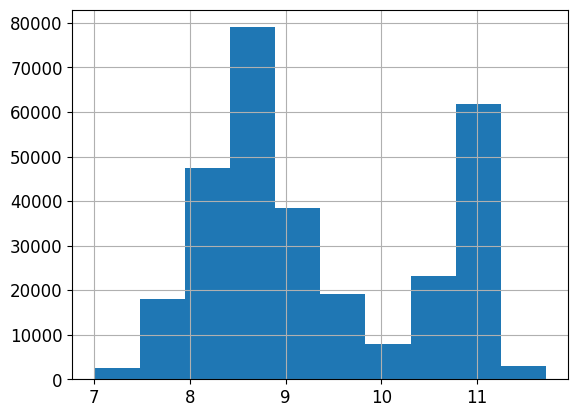

In [235]:
df[dep_var].hist()

This graph shows that when taking the log of the price, it will affect the data distribution to be more centered, which is better for dealing with outlier and make the training process of the ai models safer

### Taking the last 15 records for the Test Set

In [236]:
train_validation_sets = df[:-15]
test_df = df[-15:]

In [237]:
# from sklearn.model_selection import train_test_split

# # lets make a training, validation and test splits
# train_validation_sets, test_df = train_test_split(
#     df, test_size=0.2, random_state=42)

# train_df , val_df = train_test_split(
#     train_validation_sets, test_size=0.25, random_state=42)

### Splitting Train_Validation sets into 70% , 30% 

In [238]:
df = train_validation_sets
splits = RandomSplitter(valid_pct=0.3,seed=42)(df)

In [239]:
len(splits[0]),len(splits[1]),len(df)

(210097, 90041, 300138)

### Processing the data 

In [240]:
procs = [Categorify, FillMissing]

In [241]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [242]:
to = TabularPandas(df, procs,cat,cont,y_names=dep_var,splits=splits)

In [243]:
# fastai provides this save method that uses the Python pickle system that saves 
# nearly any Python Object, very cool

save_pickle('./to.pkl',to)

#### Creating the Decision Tree

In [244]:
to = load_pickle('./to.pkl')

##### extracting the independent variables and the target variables

In [245]:
# extract the pandas dataframe inorder to work with the machine learning and deep learning models 
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [247]:
from sklearn.tree import DecisionTreeRegressor

In [248]:
m = DecisionTreeRegressor()
m.fit(xs,y)

DecisionTreeRegressor()

#### making a error metric root mean square error

In [249]:
import math
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [250]:
m_rmse(m,xs,y), m_rmse(m,valid_xs,valid_y)

(0.006957, 0.154666)

why the training error is very low ? compared to the validation error? 

In [251]:
m.get_n_leaves(), len(xs)

(72840, 210097)

the number of leaf nodes in the decision tree is 72,000+ which is a huge amount of leafs
it means that the decision tree nearly memorized the dataset

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25).fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, to.valid.xs, to.valid.y)

(0.150143, 0.161295)

now it's much better 

In [253]:
m.get_n_leaves()

5945

very nice, the decision tree generalizes well, which is what we want

### Create a RandomForest

we saw how strong a single decision tree is, it basically got a very low rmse of 0.161295, image we have multiple trees all are trained using the same dataset, but the trick is to take random rows and columns from the dataset, & train these decision trees. note we are training a bunch of trees(e.g. 40 trees) all will produce different errors, and different results. if we take the averge of these uncorrelated errors the avg of these errors will equal 0, this is a famous concept in statistics, when you have a large number of uncorrelated errors, the avg of them is 0. 

`example`: if you flip the coin 7 times, you will surely see some bias for either heads or tails. but if you continue to flip the coin a couple of hundred times, surely at one point the amount of tails and the amount of heads will be equal and their will be no bias. the same thing for large number of uncorrelated errors, after some time they will all cancel each other and we will reach an avg of 0 for the errors. 

## graph of the errors using ipad - here

In [254]:
from sklearn.ensemble import RandomForestRegressor

# we will make a function to traverse and try different parameters for the RandomForest
# n_estimators = 40 --> number of trees, if you have time and enough sleep increase this number
# max_samples = 200,000 rows , but we have 192,000 train datapoints , let's see if anything here breaks 
# max_features = 0.5 --> randomly take half the columns to train a single tree
# min_samples_leaf= 5 --> the final leaf node shall contain at least 5 rows of data (5 airplane tickets)
# n_jobs = -1 --> tell sklearn to use all of our CPU brain power to run this in parallel
# oob_score = True --> explain this later

# things to test here, increase the # of trees, use sklearn default max_feature, use the min_samples_leaf default of sklearn
# then report your findings
def rf(xs, y, n_estimators=50, max_samples=160_000, max_features=0.5, min_samples_leaf=4, **kwargs):
    return RandomForestRegressor(n_estimators=n_estimators, max_samples=max_samples, 
                                 max_features=max_features, min_samples_leaf=min_samples_leaf,
                                 oob_score=True , n_jobs=-1).fit(xs,y)

In [255]:
m = rf(xs,y)

In [256]:
m_rmse(m,xs,y), m_rmse(m,valid_xs,valid_y)

(0.108305, 0.130662)

### Feature Importances 

In [257]:
def rf_feature_importance(m,df):
  return pd.DataFrame(
    {'cols':df.columns, 'imp':m.feature_importances_}
  ).sort_values('imp',ascending=False)
  

In [258]:
fi = rf_feature_importance(m,xs)
fi

,cols,imp
7,class,0.746870
1,flight,0.075196
9,days_left,0.064082
0,airline,0.047222
8,duration,0.032872
4,stops,0.014047
6,destination_city,0.008109
2,source_city,0.006776
3,departure_time,0.002418
5,arrival_time,0.002408


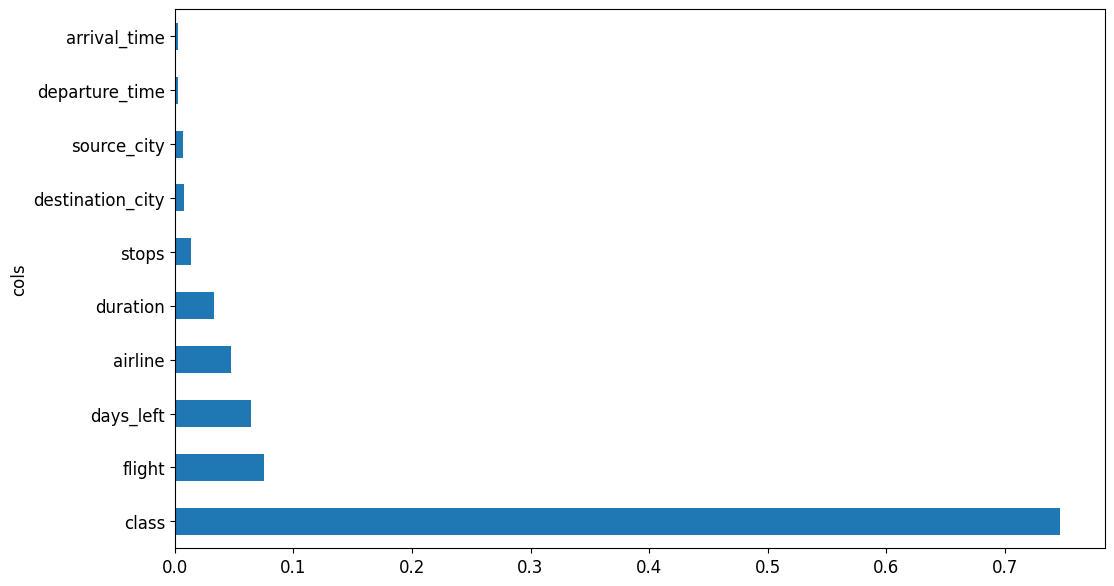

In [259]:
def plot_fi(fi): 
  return fi.plot('cols','imp','barh', figsize=(12,7),legend=False)

plot_fi(fi);

In [260]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep),len(fi.cols)

(8, 10)

working with less features is much better than working with more features, even for the long term

In [261]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [262]:
m = rf(xs_imp,y)

In [263]:
m_rmse(m,xs_imp,y), m_rmse(m,valid_xs_imp,valid_y)


(0.11277, 0.13536)

In [264]:
xs_final = xs_imp
valid_xs_final = valid_xs_imp

In [265]:
save_pickle('./xs_final.pkl',xs_final)
save_pickle('./valid_xs_final.pkl',valid_xs_final)

the save_pickle is a fastai function that will save nearly most python object in the .pkl format

## Final chosen Features

In [266]:
xs = load_pickle('./xs_final.pkl')
val_xs = load_pickle('./valid_xs_final.pkl')

In [267]:
m = rf(xs, y)
m_rmse(m, xs, y), m_rmse(m, val_xs, valid_y)

(0.112842, 0.135565)

### USING NEURAL NETWORKS

In [268]:
# copying the main training and validation dataset 
# we will deal with in terms of cleaning the dataset a bit differently 
# because neural networks are sensitive to outliers, unlike decision trees and random forest
df_nn = train_validation_sets.copy()

In [269]:
df_nn_final = df_nn[xs.columns.tolist() +[dep_var]].copy()

In [270]:
df_nn_final['days_left'] = df_nn_final['days_left'].astype(float)

In [271]:
df_nn_final

,class,flight,days_left,airline,...,stops,destination_city,source_city,price
0,Economy,SG-8709,1.0,SpiceJet,...,zero,Mumbai,Delhi,8.691651
1,Economy,SG-8157,1.0,SpiceJet,...,zero,Mumbai,Delhi,8.691651
2,Economy,I5-764,1.0,AirAsia,...,zero,Mumbai,Delhi,8.692154
3,Economy,UK-995,1.0,Vistara,...,zero,Mumbai,Delhi,8.691986
4,Economy,UK-963,1.0,Vistara,...,zero,Mumbai,Delhi,8.691986
...,...,...,...,...,...,...,...,...,...
300133,Business,UK-834,49.0,Vistara,...,one,Hyderabad,Chennai,10.848502
300134,Business,UK-838,49.0,Vistara,...,one,Hyderabad,Chennai,10.848502
300135,Business,UK-838,49.0,Vistara,...,one,Hyderabad,Chennai,10.848502
300136,Business,UK-834,49.0,Vistara,...,one,Hyderabad,Chennai,10.848502


for the neural networks, we cannot just use the normal hot encoding, this will use alot more memory and the model can't really find relationships from this kind of categorifying things compared with the Embeddings.

Embeddings will allow the features to have more meaning. "add more explanation here later"

anything lower than 9000 unique values, use Embeddings for the columns that are categories

In [ ]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000,dep_var=dep_var)

In [273]:
df_nn_final[cat_nn].nunique()

class                  2
flight              1561
airline                6
stops                  3
destination_city       6
source_city            6
dtype: int64

In [274]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn,
                      cont_nn, splits=splits, y_names=dep_var)

In [275]:
dls = to_nn.dataloaders(1024) # do not require much GPU ram

In [276]:
y = to_nn.train.y

it's generally better to have a y_range=(min,max) for the neural network - add more details later here

In [277]:
y.min(),y.max()

(7.007601, 11.672549)

In [334]:
learn = tabular_learner(dls, y_range=(7,12), layers=[100,50],
                        n_out=1, loss_func=F.mse_loss)

so what's inside the neural network, what is it's components ? 

In [335]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(1562, 98)
    (2): Embedding(7, 5)
    (3): Embedding(4, 3)
    (4-5): 2 x Embedding(7, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=121, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): fastai.layers.SigmoidRange(low=7, high=12)
  )
)

In [336]:
learn.fit_one_cycle(5, 1e-2,wd=0.1) # weight decay

epoch,train_loss,valid_loss,time
0,0.066163,0.057977,00:03
1,0.036170,0.034291,00:03
2,0.030781,0.030132,00:03
3,0.026007,0.026284,00:03
4,0.022600,0.024462,00:03


In [337]:
preds,targets = learn.get_preds()
r_mse(preds, targets) # results on the validation set

0.156404

this result is based on the validation set, because to_nn will take the data and split them to train and validation sets, so you can see the training loss and validation loss.

# Testing the neural network on a full dataset

In [282]:
from sklearn.model_selection import train_test_split

train_df , val_df = train_test_split(
    train_validation_sets, test_size=0.25, random_state=42)

In [283]:
train_df = train_df[xs.columns.tolist() + [dep_var]]
val_df = val_df[xs.columns.tolist() + [dep_var]]
test_df = test_df[xs.columns.tolist() + [dep_var]]

val_y = val_df['price']
train_y = train_df[dep_var]
test_targets = test_df[dep_var]

In [284]:
dl = learn.dls.test_dl(train_df)
dl_val = learn.dls.test_dl(val_df)
dl_test = learn.dls.test_dl(test_df)

In [285]:
preds, _ = learn.get_preds(dl=dl)
preds_val, _ = learn.get_preds(dl=dl_val)
preds_test, _ = learn.get_preds(dl=dl_test)

In [286]:
r_mse(to_np(preds.squeeze()),train_y) , r_mse(to_np(preds_val.squeeze()),val_y) 

(0.149342, 0.148423)

In [287]:
# test results - this test set really shows how good the model is doing
r_mse(to_np(preds_test.squeeze()),test_targets) 

0.27271

### using XGBoost 

In [288]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

In [289]:

from sklearn.model_selection import train_test_split

train_df , val_df = train_test_split(
    train_validation_sets, test_size=0.25, random_state=42)

# Load the TabularPandas object
to = load_pickle('./to.pkl')

test_df = df[-15:]
test_targets = test_df[dep_var]

# using the "tabularPandas" datacleaning to automatically apply changes to the following dataset
dl_test = to.dataloaders().test_dl(test_df)


In [290]:
# extract the xs(independent variables) from the dl_test dataloader
# which contains the test df preprocessed and ready to use
test_df = dl_test.train.xs
test_targets= dl_test.train.y

# make sure that you only get the final columns after "feature importance"
test_df = test_df[xs.columns.to_list()] 

In [291]:
# extract the pandas dataframe inorder to work with the machine learning and deep learning models 
y = to.train.y
valid_y = to.valid.y

In [292]:
xs = load_pickle('./xs_final.pkl')
val_xs = load_pickle('./valid_xs_final.pkl')

In [293]:
# making and fitting the xgboost models in a function
def xgboost(xs, y, **params):
    # using the GPU - for better training
    params['device'] = 'cuda'    
    # make a single model
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(xs, y)

    return model

In [294]:
def rf(xs, y, n_estimators=50, max_samples=140_000, max_features=0.5, min_samples_leaf=4, **kwargs):
    return RandomForestRegressor(n_estimators=n_estimators, max_samples=max_samples, 
                                 max_features=max_features, min_samples_leaf=min_samples_leaf,
                                 oob_score=True , n_jobs=-1).fit(xs,y)

In [295]:
m_xgb = xgboost(xs,y,learning_rate=0.3, n_estimators=700,
                  max_depth=10, subsample=0.9, colsample_bytree=0.7)

m_rf = rf(xs,y)

In [296]:
preds_xgb= m_xgb.predict(val_xs)
preds_rf = m_rf.predict(val_xs)

r_mse(preds_xgb,valid_y), r_mse(preds_rf,valid_y)

(0.12147, 0.136672)

### "THE TESTING SET"

In [297]:
preds_xgb= m_xgb.predict(test_df)
preds_rf = m_rf.predict(test_df)

r_mse(preds_xgb,test_targets), r_mse(preds_rf,test_targets) 

(0.042777, 0.074388)

very promising results for both bagging and boosting techniques

### Making functions for code Reusability

In [298]:
def load_data():
    """
    This function will load all the data again directly from the clean dataset


    Returns:
        - The whole dataset 
        - The target price of the whole dataset
        - train_validation_sets, test_df -- last 15 records for test_df
    """
    df = pd.read_csv(
        'flight-price-prediction/Clean_Dataset.csv', low_memory=False)
    df.drop(columns=['Unnamed: 0'], inplace=True)

    dep_var = 'price'
    df[dep_var] = np.log(df[dep_var])  # 300153

    train_validation_sets = df[:-15]  # 300138 rows
    test_df = df[-15:]  # 15 rows

    df_y = df[dep_var]

    return df, df_y, train_validation_sets, test_df


def test_nn_data(test_df, learn):
    """
    This function will load the 'tabular pandas object' 
    it will pre-process the 'test_df' for both the neural network 
    and for the 2 trees { random-forest, xgboost }

    Returns:
        xs, val_xs : final indepented variables used to train ensemble of tress { random forest, xgboost }
        y, valid_y : final target variable to check the rmse for training and validation 
        test_df : used for the testing the trees { random forest, xgboost }
        dl_test_nn : used for testing the NN  
        test_targets : used for finding the rmse between preds and targets for both ensembles of trees and NN

    """

    # Load the TabularPandas object
    to = load_pickle('./to.pkl')
    y = to.train.y
    valid_y = to.valid.y
    xs = load_pickle('./xs_final.pkl')
    val_xs = load_pickle('./valid_xs_final.pkl')

    test_df_nn = test_df[xs.columns.tolist() + [dep_var]]
    dl_test_nn = learn.dls.test_dl(test_df_nn)

    dl_test = to.dataloaders().test_dl(test_df)
    test_df = dl_test.train.xs
    test_targets = dl_test.train.y

    # make sure that you only get the final columns after "feature importance"
    test_df = test_df[xs.columns.to_list()]

   

    return xs, val_xs, y, valid_y, test_df, test_targets, dl_test_nn

In [299]:
# making a nn to feed it inside the kfold function
# remember we are dealing with the 'whole dataset' to train and test all the models and see the 'rmsle'

# return the deeplearning model
def nn():
    learn = tabular_learner(dls, y_range=(7, 12), layers=[100, 50],
                            n_out=1, loss_func=F.mse_loss)
    with learn.no_bar(), learn.no_logging(): learn.fit_one_cycle(5, 1e-2)
    return learn


# return the training predictions
def nn_predict_train(learn, X_train):
    X_train = X_train[xs.columns.tolist() + [dep_var]]
    dl = learn.dls.test_dl(X_train)
    preds, _ = learn.get_preds(dl=dl)
    return to_np(preds.squeeze())


# return the validation predictions
def nn_predict_val(learn, val_xs):
    val_xs = val_xs[xs.columns.tolist() + [dep_var]]
    dl_val = learn.dls.test_dl(val_xs)
    preds, _ = learn.get_preds(dl=dl_val)
    return to_np(preds.squeeze())

 
#### now setting up the data for xgboost and rf
 

In [300]:

def data_for_trees(X_train, val_xs):
    # Load the TabularPandas object
    to = load_pickle('./to.pkl')
    xs = load_pickle('./xs_final.pkl')

    # preprocess the data using the magical method test_dl()
    dl_train = to.dataloaders().test_dl(X_train)
    dl_val = to.dataloaders().test_dl(val_xs)

    train_df = dl_train.train.xs
    test_targets = dl_train.train.y  # remember there is no train targets here

    val_df = dl_val.train.xs
    val_targets = dl_val.train.y  # remember there is no train targets here
    

    # make sure that you only get the final columns after "feature importance"
    train_df = train_df[xs.columns.to_list()]
    val_df = val_df[xs.columns.tolist()]
    
    return train_df, val_df

# KFOLD ON THE WHOLE DATASET

In [301]:
def train_and_evaluate(X_train, train_targets, val_xs, val_targets, **params):
    
    train_df, val_df = data_for_trees(X_train, val_xs)

    xgb = xgboost(train_df, train_targets, learning_rate=0.3, n_estimators=700,
                  max_depth=10, subsample=0.9, colsample_bytree=0.7)  # first model created and trained

    rf_model = rf(train_df, train_targets, max_samples=X_train.shape[0])

    # add here the neural network
    learn = nn()
    

    # training rmse
    xgb_preds_train = xgb.predict(train_df)
    rf_preds_train = rf_model.predict(train_df)
    nn_preds_train =nn_predict_train(learn,X_train)
    
    # nn_preds_train,_ = learn.get_preds(dl=dl)
    combined_preds_train = [xgb_preds_train, rf_preds_train,nn_preds_train]

    preds_train = np.stack(combined_preds_train).mean(0)
    ensembled_train_rmse = r_mse(preds_train, train_targets)



    # validation rmse
    xgb_preds_val = xgb.predict(val_df)
    rf_preds_val = rf_model.predict(val_df)
    nn_preds_val = nn_predict_val(learn,val_xs)
    
    combined_preds_val = [rf_preds_val, xgb_preds_val,nn_preds_val]
    preds_val = np.stack(combined_preds_val).mean(0)
    ensembled_validation_rmse = r_mse(preds_val, val_targets)
    
    
    # printing results
    # print(f'Validation rmse: {ensembled_validation_rmse} || Training rmse: {ensembled_train_rmse} ')

    return ensembled_validation_rmse, ensembled_train_rmse, xgb, rf_model,learn

In [302]:
# load the data
df, df_y, train_validation_sets, test_df = load_data()

In [304]:
def ensemble_kfold_params(n_splits):
    train_rootmse, val_rootmses, models= [],[],[]
    kfold = KFold(n_splits,shuffle=True,random_state=42)
    count = 0
    for train_idxs, val_idxs in kfold.split(df):
        X_train, train_targets = df.iloc[train_idxs], df_y.iloc[train_idxs]
        X_val, val_targets = df.iloc[val_idxs], df_y.iloc[val_idxs]
        count+=1
        print(f'Kfold Number { count }')
        val_rmse, train_rmse,xgb,m_rf,learn = train_and_evaluate(
            X_train,
            train_targets,
            X_val,
            val_targets)
        models_from_trainEval = [xgb,m_rf,learn]
        train_rootmse.append(train_rmse)
        val_rootmses.append(val_rmse)
        models.append(xgb)
        models.append(m_rf)
        models.append(learn)
        
    print(f'Train rmse: {np.mean(train_rootmse):.4f}, validation rmse: {np.mean(val_rootmses):.4f}')
    return models

In [305]:
models = ensemble_kfold_params(5)


Kfold Number 1


Kfold Number 2


Kfold Number 3


Kfold Number 4


Kfold Number 5


Train rmse: 0.0920, validation rmse: 0.1188


In [307]:
def predict_avg(models, inputs):
  pred_nn = []
  df, df_y, train_validation_sets, test_df = load_data()
  for model in models: 
    if isinstance(model, TabularLearner):
        dl_test_nn = learn.dls.test_dl(test_df)
        pred, _ = model.get_preds(dl=dl_test_nn)
        pred = to_np(pred.squeeze())
        pred_nn.append(pred)
      
    else: 
      pred_nn.append(model.predict(inputs))
    
  if not pred_nn:
    raise ValueError('Please run the code starting with the kfold function')

  return np.mean(pred_nn,axis=0)

In [308]:
def rf(xs, y, n_estimators=50, max_samples=210_000, max_features=0.5, min_samples_leaf=4, **kwargs):
    return RandomForestRegressor(n_estimators=n_estimators, max_samples=max_samples, 
                                 max_features=max_features, min_samples_leaf=min_samples_leaf,
                                 oob_score=True , n_jobs=-1).fit(xs,y)

In [309]:
df, df_y, train_validation_sets, test_df = load_data()

In [310]:
learn = nn()
xs, val_xs, y, valid_y, test_df, test_targets, dl_test_nn = test_nn_data(test_df,learn)

In [313]:
learn = tabular_learner(dls, y_range=(7,12), layers=[100,50],
                        n_out=1, loss_func=F.mse_loss)
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.065654,0.044572,00:02
1,0.036312,0.037088,00:03
2,0.031082,0.029493,00:02
3,0.026144,0.026294,00:03
4,0.022944,0.024403,00:03


In [ ]:

m_xgb = xgboost(xs,y,learning_rate=0.3, n_estimators=700,
                  max_depth=10, subsample=0.9, colsample_bytree=0.7)

m_rf = rf(xs,y)


preds_xgb= m_xgb.predict(val_xs)
preds_rf = m_rf.predict(val_xs)

preds_xgb_test= m_xgb.predict(test_df)
preds_rf_test = m_rf.predict(test_df)

# NN prediction
preds_test, _ = learn.get_preds(dl=dl_test_nn)

preds_kfold = predict_avg(models,test_df)


print(f'RF Training rmse: {m_rmse(m_rf,xs,y)} || XGBOOST Training rmse: {m_rmse(m_xgb,xs,y)}')
print(f'RF Validation: {r_mse(preds_rf,valid_y)} || XGBOOST VALIDATION: {r_mse(preds_xgb,valid_y)} ')
print(f'RF on Test Set {r_mse(preds_rf_test,test_targets)} || XGBOOST on Test Set: {r_mse(preds_xgb_test,test_targets)} || NN Test set: {r_mse(to_np(preds_test.squeeze()),test_targets)} || K-Fold Test set: {r_mse(preds_kfold,test_targets)}')

RF Training rmse: 0.10644 || XGBOOST Training rmse: 0.054838
RF Validation: 0.132329 || XGBOOST VALIDATION: 0.12147 
RF on Test Set 0.149229 || XGBOOST on Test Set: 0.132311 || NN Test set: 0.266885 || K-Fold Test set: 0.131619


### final verdict: 

- XGBOOST on Test Set: 0.124016 -- `BEST ONE`

- RF on Test Set 0.149946

- NN Test set: 0.256161

- K-Fold Test set: 0.137458

#### ENSEMBLING 

In [315]:
# using all of the above preds and giving them all the same weight
# so no model have higher importance than others

combined_predictions = [preds_kfold,to_np(preds_test.squeeze()),preds_rf_test,preds_xgb_test]
combined_predictions
preds=np.stack(combined_predictions).mean(0)
r_mse(preds,test_targets)

0.155969

In [333]:
import numpy as np

# Assign weights to each model's predictions
# we removed the neural network since the kfold,& trees are doing much better
# we assign weights to each predition, more accurate predictions such as XGBOOST
# --> Recieves more importance
# this results in finding very good results indeed, lowest error till now in this notebook :)
# rule: the weights must add up to one

# where is this idea from: resources must stated here, such a powerful idea
combined_predictions = [
    preds_kfold * 0.39,
    preds_rf_test * 0.01,
    preds_xgb_test * 0.6,
]

# Compute the weighted average
preds_weighted = np.sum(combined_predictions, axis=0)

# Calculate RMSLE of the ensemble
ensemble_rmsle = r_mse(preds_weighted, test_targets)

# Output result
print(f"Weighted Ensemble RMSLE: {ensemble_rmsle}")

# 122329

Weighted Ensemble RMSLE: 0.12172


Resources:

fastai Practical deep learning for coders - https://course.fast.ai/

fast ai documentation 

sklearn documentation 

sklearn full tutorial - https://www.youtube.com/watch?v=hDKCxebp88A 

sklearn full tutorial notebooks - https://jovian.ai/aakashns/python-gradient-boosting-machines

ChatGpt:

1. used to enhance productivity to learn the description of functions,
2. to explain funcitons
3. to explain ways to use the GPU to train models faster
4. to know functions that are in libararies such as: pandas, sklearn, fastai; Rather than reading the whole documentation of the 3 libraries to find what function can help with the project, which can be overwhelming


  